In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas


Using TensorFlow backend.


In [309]:
genres_df = pandas.read_csv('data/genres.csv').set_index('movie')
genres_mat = np.matrix(genres_df.reset_index(drop=True))
genres = genres_df.columns

In [517]:
import os

dim = (100, 100)
channels = 3

poster_ids = []
poster_data = []
posters_dir = 'posters/'
for movie, row in genres_df.iterrows():
    img_path = '{}/{}.jpg'.format(posters_dir, movie)
    img = image.load_img(img_path, target_size=dim, color_mode='rgb')
    x = image.img_to_array(img)
    poster_data.append(x)
    poster_ids.append(movie)
poster_data = np.array(poster_data)
poster_data.shape

(1029, 100, 100, 3)

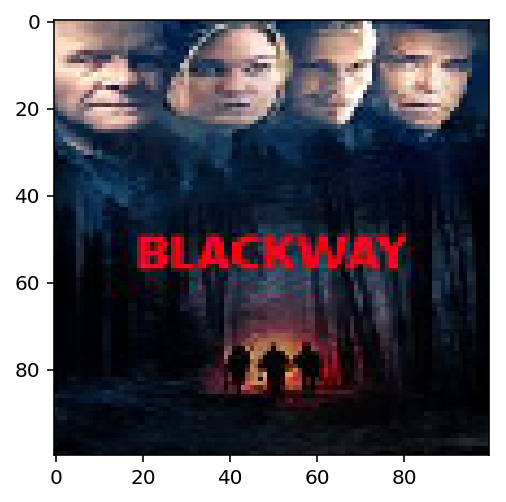

In [518]:
plt.imshow(poster_data[0]/255.)

In [541]:
train_data = poster_data[200:]
test_data = poster_data[0:200]

train_genres = genres_mat[200:]
test_genres = genres_mat[0:200]

x_train = train_data.astype('float32') / 255.
x_test = test_data.astype('float32') / 255.

print "Training Set: %d\n" % len(train_data),
print "Test Set: %d" % len(test_data),

Training Set: 829
Test Set: 200


In [520]:
def get_encoder(input_img):
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
               input_shape=(dim[0], dim[1], channels))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return encoded

def get_decoded(encoded):
    # input dim is the dimension of the encoder (13, 13, 8)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same', input_shape=(dim[0], 
        dim[1], channels), data_format="channels_last")(x)
    return decoded

input_img = Input(shape=(dim[0], dim[1], channels))
encoded = get_encoder(input_img)
decoded = get_decoded(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 50, 50, 16)        9232      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 25, 25, 16)        2320      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 13, 13, 16)        0         
__________

In [546]:
# create encoder
encoder = Model(input_img, encoded)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 50, 50, 16)        9232      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 25, 25, 16)        2320      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 13, 13, 16)        0         
Total para

In [547]:
encoding_dim = 13, 13, 16

# create decoder, by extracting latter half of the autoencoder's layers
num_encoder_layers = len(encoder.layers)
decoder_layers = len(autoencoder.layers)-num_encoder_layers

encoded_input = Input(shape=encoding_dim)
cur_layer = encoded_input
for l_num in range(decoder_layers):
    cur_layer = autoencoder.layers[num_encoder_layers+l_num](cur_layer)

decoder = Model(encoded_input, cur_layer)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_227 (Conv2D)          multiple                  2320      
_________________________________________________________________
up_sampling2d_96 (UpSampling multiple                  0         
_________________________________________________________________
conv2d_228 (Conv2D)          multiple                  2320      
_________________________________________________________________
up_sampling2d_97 (UpSampling multiple                  0         
_________________________________________________________________
conv2d_229 (Conv2D)          multiple                  9280      
_________________________________________________________________
up_sampling2d_98 (UpSampling multiple                  0         
__________

In [526]:
# run 10 epochs of training
autoencoder.fit(x_train, x_train,
                epochs=60,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 829 samples, validate on 200 samples
Epoch 1/60
829/829 [==============================] - 25s 30ms/step - loss: 0.5850 - val_loss: 0.5383
Epoch 2/60
829/829 [==============================] - 29s 34ms/step - loss: 0.5515 - val_loss: 0.6246
Epoch 3/60
829/829 [==============================] - 30s 36ms/step - loss: 0.5388 - val_loss: 0.5068
Epoch 4/60
829/829 [==============================] - 30s 36ms/step - loss: 0.5198 - val_loss: 0.4792
Epoch 5/60
829/829 [==============================] - 26s 31ms/step - loss: 0.5117 - val_loss: 0.5110
Epoch 6/60
829/829 [==============================] - 25s 31ms/step - loss: 0.5076 - val_loss: 0.4780
Epoch 7/60
829/829 [==============================] - 25s 30ms/step - loss: 0.4991 - val_loss: 0.4971
Epoch 8/60
829/829 [==============================] - 25s 31ms/step - loss: 0.4995 - val_loss: 0.4734
Epoch 9/60
829/829 [==============================] - 25s 30ms/step - loss: 0.4949 - val_loss: 0.4659
Epoch 10/60
829/829 [===============

In [527]:
# encode and decode test images
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

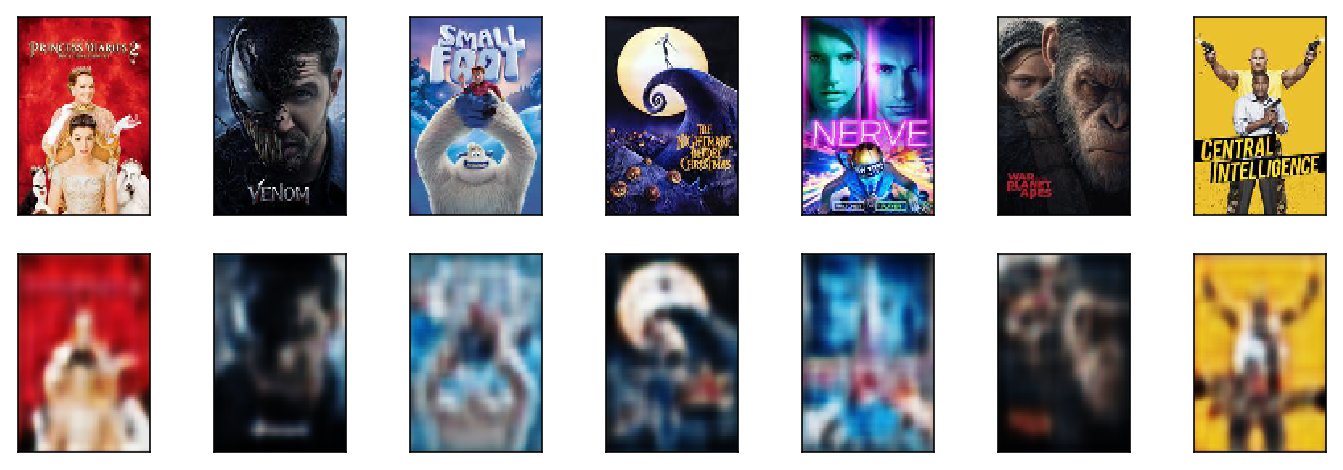

In [528]:

# plot first 10 images and autoencoded representations

plt_figs = x_test[3:10]
plt_dec_figs = decoded_imgs[3:10]

n = len(plt_figs)
plt.figure(figsize=(12, 4))
for i in range(n):
    
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(plt_figs[i], aspect=1.5)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(plt_dec_figs[i], aspect=1.5)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.savefig('output/VAE_dec.png', dpi=300)

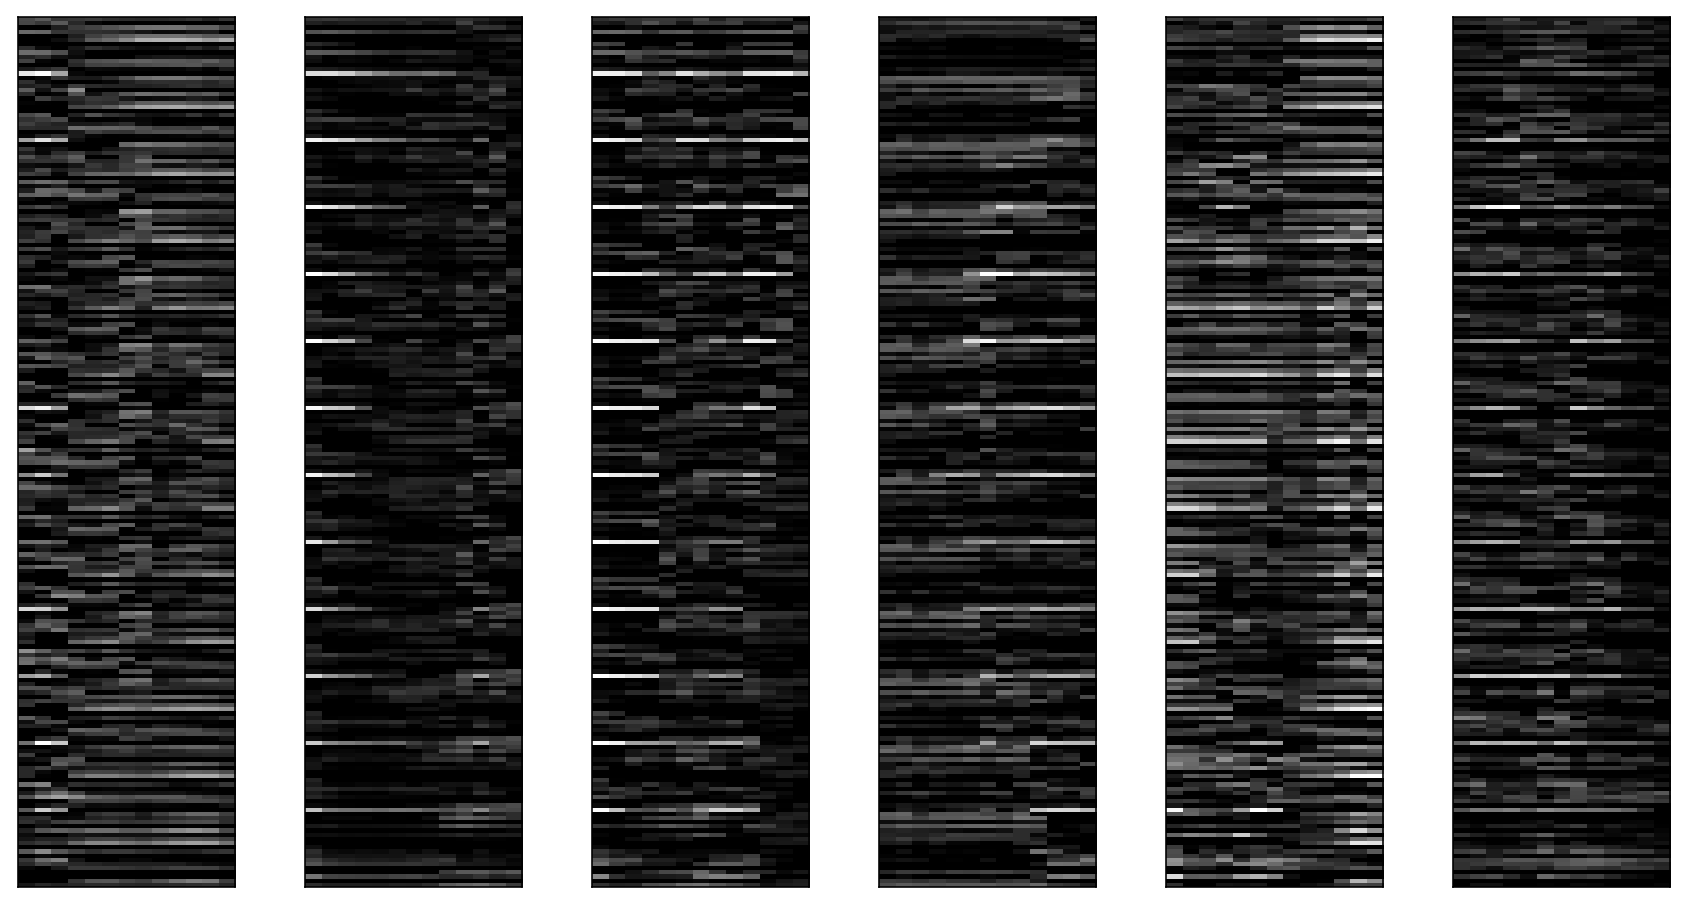

In [529]:
# visualize encodings of the first 10 images
n = 6
plt.figure(figsize=(15, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(13, 13 * 16).T, aspect=0.25)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('output/VAE_enc.png', dpi=300)


In [531]:
encoded_train_imgs = encoder.predict(x_train)

In [532]:
from sklearn.manifold import TSNE

def get_tsne(perplexity):
    tsne = TSNE(n_components=2, random_state=0,perplexity=perplexity)
    shp = encoded_train_imgs.shape
    encoded_reshaped = encoded_train_imgs.reshape((shp[0], shp[1]*shp[2]*shp[3]))
    x_train_2d = tsne.fit_transform(encoded_reshaped)
    return x_train_2d

def plot_tsne(x_train_2d, perplexity):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    #plt.title(perplexity)

    w,h = 3, 4.5
    w_2, h_2 = w/2., h/2.
    
    for i in np.arange(0, len(x_train_2d), 1):
        x, y = x_train_2d[i]
        img = x_train[i]
        ax.imshow(img, extent=[x-w_2, x+w_2, y-h_2, y+h_2], aspect=1., zorder=2)
    ax.axis('off')

    ax.scatter(x_train_2d[:, 0], x_train_2d[:, 1], s=1, zorder=1)
    plt.savefig('output/tSNE_{}.png'.format(perplexity), dpi=300)


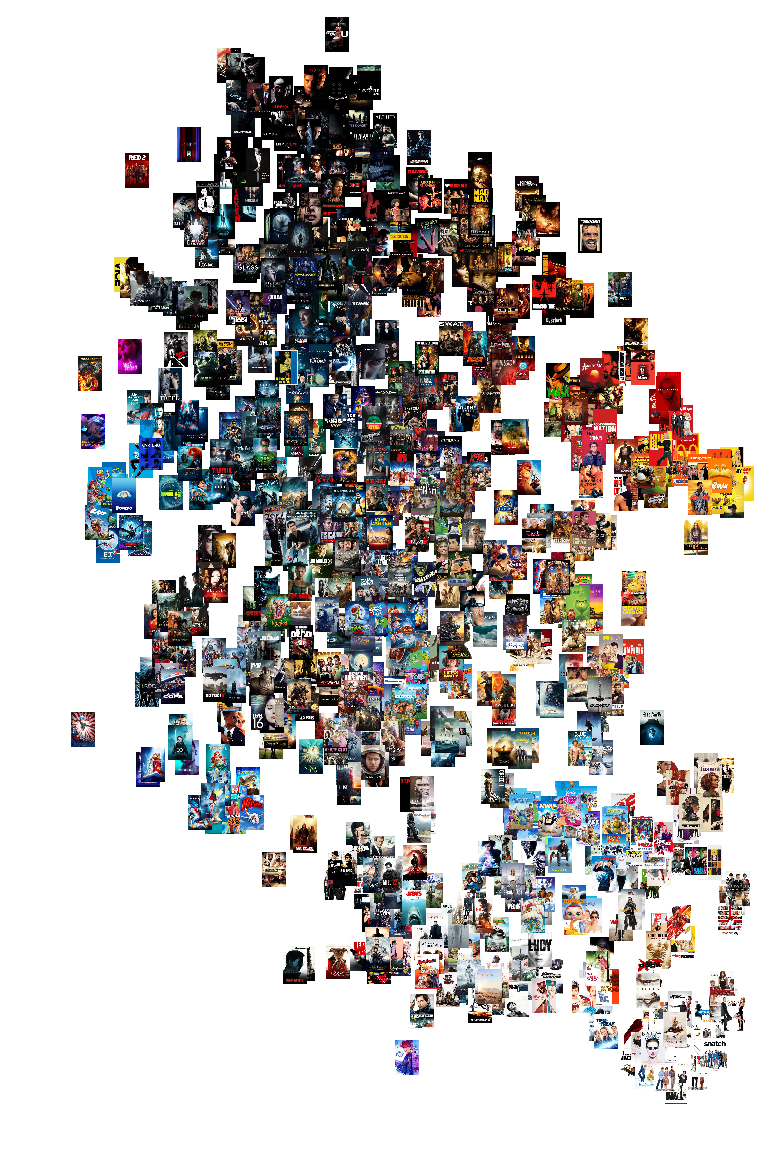

In [553]:
perplexity = 8
x_train_2d = get_tsne(perplexity)
plot_tsne(x_train_2d, perplexity)

In [554]:

def plot_genre(x_train_2d, plot_genres, colors):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x_train_2d[:, 0], x_train_2d[:, 1], s=10, zorder=1, color='#dfdfdf')

    labels = []
    for i in range(len(plot_genres)):
        genre = plot_genres[i]
        color = colors[i]
        g_index = np.where(genres == genre)
        action_indices = train_genres[:, g_index].A1.astype(bool)
        action_train_2d = x_train_2d[action_indices, ]
        ax.scatter(action_train_2d[:, 0], action_train_2d[:, 1], s=30, zorder=2, edgecolor='#dfdfdf', color=None)
        lab = ax.scatter(action_train_2d[:, 0], action_train_2d[:, 1], s=20, zorder=3, color=color, label=genre)
        labels.append(lab)
    plt.legend(handles=labels)
    ax.axis('off')
    
    plt.savefig('output/{}.jpg'.format(genre), dpi=300)


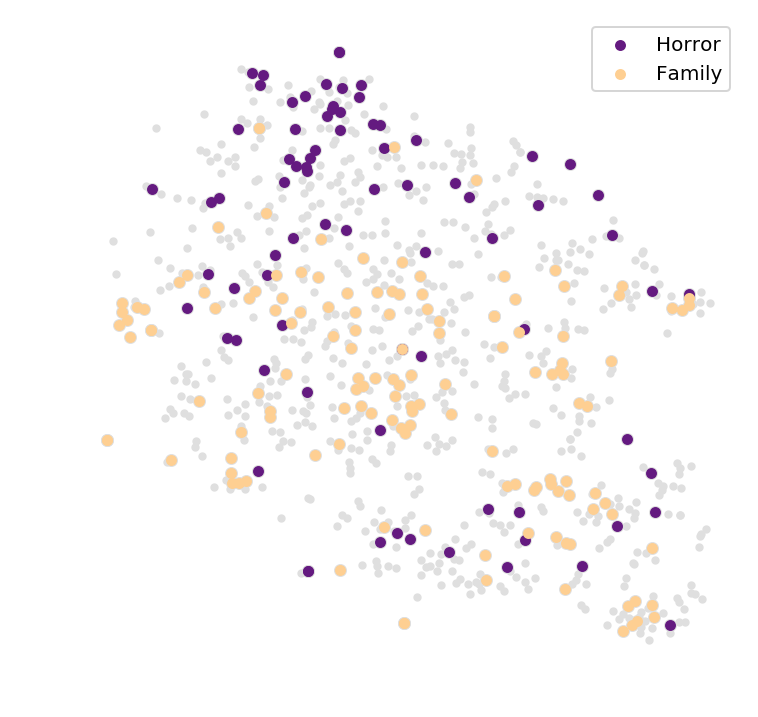

In [555]:
plot_genre(x_train_2d, ['Horror', 'Family'], [plt.get_cmap('magma')(0.3), plt.get_cmap('magma')(0.9)])

In [556]:
from scipy.stats import norm

def generate_samples(genre, encoder, decoder, x_train, genres):

    # what does the latent space look like for this genre?
    g_index = np.where(genres == genre)
    action_indices = train_genres[:, g_index].A1.astype(bool)
    encoded_horror = encoder.predict(x_train[action_indices, ])

    shape = encoded_horror.shape
    encoded_reshaped = encoded_horror.reshape((shape[0], shape[1]*shape[2]*shape[3]))

    encoded_means = encoded_reshaped.mean(axis=0)
    encoded_stds = encoded_reshaped.std(axis=0)
    encoded_dist = np.zeros((2, encoded_means.shape[0]))
    encoded_dist[0] = encoded_means
    encoded_dist[1] = encoded_stds
    encoded_dist = pandas.DataFrame({'mean': encoded_means, 'std': encoded_stds})

    encoded_sample = encoded_dist.apply(lambda l: norm.rvs(loc=l['mean'], scale=l['std']), axis=1)
    encoded_sample = np.array(encoded_sample)
    encoded_sample = encoded_sample.reshape((1, shape[1], shape[2], shape[3]))
    predicted_sample = decoder.predict(encoded_sample)
    plt.imshow(predicted_sample[0])
    plt.xticks([])
    plt.yticks([])


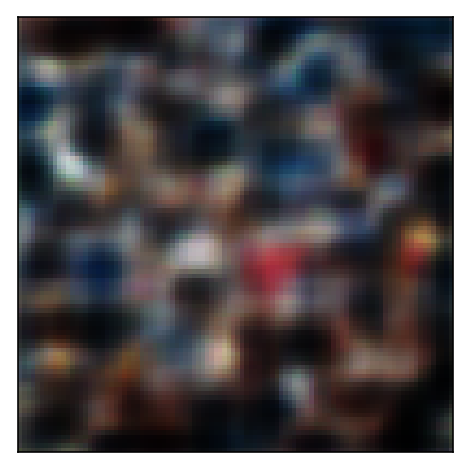

In [557]:
generate_samples('Horror', encoder, decoder, x_train, genres)

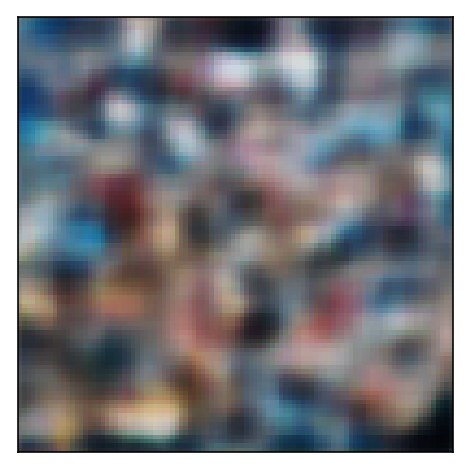

In [558]:
generate_samples('Family', encoder, decoder, x_train, genres)